In [13]:
from luxpy import (cat, colortf, _CIEOBS, _CIE_ILLUMINANTS, _CRI_RFL, _CIE_D65,_CIE_E,
                   spd_to_xyz, plot_color_data, math, cie_interp, getwlr, xyz_to_srgb)
from luxpy.utils import np, plt, sp, _PKG_PATH, _SEP, _EPS 
import warnings
from imageio import imsave

import tensorflow as tf
from mtcnn import MTCNN
from pathlib import Path
import pandas as pd
import glob
import cv2
import csv
import os
import ast
import pydot
import pydotplus
import graphviz
from datetime import datetime
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from keras.utils.vis_utils import plot_model

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
# Data Storage Lists
trainLandmarks = []
trainLandmarksRet = []
trainFileNames = []
trainIllumsRaw = []
trainIllumsRet = []

evalLandmarks = []
evalLandmarksRet = []
evalFileNames = []
evalIllumsRaw = []
evalIllumsRet = []

testFileNames = []
testDrowsiness = []

In [21]:
def frame_capture(file): # (15 frames)
    
    cap = cv2.VideoCapture(file)
    
    try:
        if not os.path.exists('data'):
            os.makedirs('data')
    except OSError:
        print('Error: Creating directory of data')
            
    current_frame = 0
    
    while True:
        ret, frame = cap.read()
#         print(file)
        if not ret:
            current_frame = 0
            break 

        if current_frame % 15 == 0:
            
            datasetDir = os.path.dirname(os.path.dirname(os.path.dirname(file)))
            indexDataset = datasetDir.rfind('\\')
            datasetDir = datasetDir[indexDataset:]
            
            parentDir = os.path.dirname(os.path.dirname(file)) # refers to <driver_num> e.g. "001, 002"
            currDir = parentDir
            
            childDir = os.path.dirname(file) # refers to where the current video file is <scenario> e.g. noglasses, glasses, etc.
            indexParent = parentDir.rfind('\\')
            parentDir = parentDir[indexParent:] # refers to <scenario> only
            
            indexChild = childDir.rfind('\\')
            childDir = childDir[indexChild:]
            
#             filename of txt document containing labels for current video
            if datasetDir[1:] == "Training Dataset":
                labelFile = currDir + "\\" + childDir[1:] + "\\" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'
            elif parentDir[1:] == "Evaluation Dataset":
                labelFile = currDir + "\\" + childDir[1:] + "\\" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'
                labelFile = labelFile.replace("mix", "mixing")
                labelFile = labelFile.replace("nightno", "night_no")
            else:
                scenario = ""
                if "sunglasses" in os.path.basename(file)[:-4]:
                    scenario = "sunglasses"
                elif "night_noglasses" in os.path.basename(file)[:-4]:
                    scenario = "night_noglasses"    
                elif "noglasses" in os.path.basename(file)[:-4]:
                    scenario = "noglasses"
                elif "night_glasses" in os.path.basename(file)[:-4]:
                    scenario = "sunglasses"
                else:
                    scenario = "glasses"
                
                labelFile = currDir + "\\" + childDir[1:] + "\\" + "test_label_txt\\" + scenario + "\\" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'
                
                if not os.path.exists(labelFile):                    
                    labelFile = currDir + "\\" + childDir[1:] + "\\" + "test_label_txt\\" + "wh" + "\\" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'
                
                labelFile = labelFile.replace("mix", "mixing")
                
                if not os.path.exists(labelFile): # if labels file is non-existent for the given video
                    continue
                
            with open(labelFile) as f:
                labels = f.readline()
            try:
                
                if datasetDir[1:] == "Training Dataset":
                    save_path = "./data/Training/" # specify where (in relation to root path to place new folder)
                    file_name = save_path + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "/" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "_" + str(current_frame) + "_" + labels[current_frame] + '.jpg'
                elif parentDir[1:] == "Evaluation Dataset":
                    save_path = "./data/Evaluation/" # specify where (in relation to root path to place new folder)
                    file_name = save_path + os.path.basename(file)[:-4] + "/" + os.path.basename(file)[:-4] + "_" + str(current_frame) + "_" + labels[current_frame] + '.jpg'
                else:
                    save_path = "./data/Testing/" # specify where (in relation to root path to place new folder)
                    file_name = save_path + os.path.basename(file)[:-4] + "/" + os.path.basename(file)[:-4] + "_" + str(current_frame) + "_" + labels[current_frame] + '.jpg'
                
#                 Creating..../data/Testing/037_sunglasses_mix/037_sunglasses_mix_7110_1.jpg
                
            except IndexError:
                continue
            
#             print('Creating...' + file_name)
            cv2.imwrite(file_name, frame)
            
            img_file = Path(file_name) # for Retinex images, use replace() to get path of same named images in order to get post-retinex illum
            
            if save_path == "./data/Training/":
                trainFileNames.append(os.path.basename(img_file)[:-4])
                trainLandmarks.append(generateLandmarks(os.path.dirname(img_file) + "\\" + os.path.basename(img_file)))
                trainIllumsRaw.append(illuminanceEstimation(img_file))
                
                retSave_path = "./data/RetTraining/" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "/"
                retinexImplement(img_file, retSave_path)
                
#               post-retinex functions
                
                retSave_path = retSave_path + os.path.basename(img_file)[:-4] + "_URetinexNet.jpg"
                trainIllumsRet.append(illuminanceEstimation(retSave_path))
            
                trainLandmarksRet.append(generateLandmarks(retSave_path))
                
                

            elif save_path == "./data/Evaluation/":
                evalFileNames.append(os.path.basename(img_file)[:-4])
                evalLandmarks.append(generateLandmarks(os.path.dirname(img_file) + "\\" + os.path.basename(img_file)))
                evalIllumsRaw.append(illuminanceEstimation(img_file))
                
                retSave_path = "./data/RetEvaluation/" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "/"
                retinexImplement(img_file, retSave_path)
                
#               post-retinex functions
                
                retSave_path = retSave_path + os.path.basename(img_file)[:-4] + "_URetinexNet.jpg"
                evalIllumsRet.append(illuminanceEstimation(retSave_path))
            
                evalLandmarksRet.append(generateLandmarks(retSave_path))
            
            else:
                testFileNames.append(os.path.basename(img_file)[:-4])
                testDrowsiness.append(labels[current_frame])
                print('Creating...' + file_name)
                
        current_frame += 1
    
#     cap.release() 

In [4]:
# def frame_capture(file): # (per frame)
    
#     cap = cv2.VideoCapture(file)
    
#     try:
#         if not os.path.exists('data'):
#             os.makedirs('data')
#     except OSError:
#         print('Error: Creating directory of data')
            
#     current_frame = 0
    
#     while True:
#         ret, frame = cap.read()
# #         print(file)
#         if not ret:
#             current_frame = 0
#             break 
            
#         datasetDir = os.path.dirname(os.path.dirname(os.path.dirname(file)))
#         indexDataset = datasetDir.rfind('\\')
#         datasetDir = datasetDir[indexDataset:]

#         parentDir = os.path.dirname(os.path.dirname(file)) # refers to <driver_num> e.g. "001, 002"
#         currDir = parentDir

#         childDir = os.path.dirname(file) # refers to where the current video file is <scenario> e.g. noglasses, glasses, etc.
#         indexParent = parentDir.rfind('\\')
#         parentDir = parentDir[indexParent:] # refers to <scenario> only

#         indexChild = childDir.rfind('\\')
#         childDir = childDir[indexChild:]

# #             filename of txt document containing labels for current video
#         if datasetDir[1:] == "Training Dataset":
#             labelFile = currDir + "\\" + childDir[1:] + "\\" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'
#         elif parentDir[1:] == "Evaluation Dataset":
#             labelFile = currDir + "\\" + childDir[1:] + "\\" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'
#             labelFile = labelFile.replace("mix", "mixing")
#             labelFile = labelFile.replace("nightno", "night_no")
#         else:
#             scenario = ""
#             if "sunglasses" in os.path.basename(file)[:-4]:
#                 scenario = "sunglasses"
#             elif "night_noglasses" in os.path.basename(file)[:-4]:
#                 scenario = "night_noglasses"    
#             elif "noglasses" in os.path.basename(file)[:-4]:
#                 scenario = "noglasses"
#             elif "night_glasses" in os.path.basename(file)[:-4]:
#                 scenario = "sunglasses"
#             else:
#                 scenario = "glasses"

#             labelFile = currDir + "\\" + childDir[1:] + "\\" + "test_label_txt\\" + scenario + "\\" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'

#             if not os.path.exists(labelFile):                    
#                 labelFile = currDir + "\\" + childDir[1:] + "\\" + "test_label_txt\\" + "wh" + "\\" + os.path.basename(file)[:-4] + "_drowsiness" + '.txt'

#             labelFile = labelFile.replace("mix", "mixing")

#         with open(labelFile) as f:
#             labels = f.readline()
#         try:

#             if datasetDir[1:] == "Training Dataset":
#                 save_path = "./data/Training/" # specify where (in relation to root path to place new folder)
#                 file_name = save_path + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "/" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "_" + str(current_frame) + "_" + labels[current_frame] + '.jpg'
#             elif parentDir[1:] == "Evaluation Dataset":
#                 save_path = "./data/Evaluation/" # specify where (in relation to root path to place new folder)
#                 file_name = save_path + os.path.basename(file)[:-4] + "/" + os.path.basename(file)[:-4] + "_" + str(current_frame) + "_" + labels[current_frame] + '.jpg'
#             else:
#                 save_path = "./data/Testing/" # specify where (in relation to root path to place new folder)
#                 file_name = save_path + os.path.basename(file)[:-4] + "/" + os.path.basename(file)[:-4] + "_" + str(current_frame) + "_" + labels[current_frame] + '.jpg'

# #                 Creating..../data/Testing/037_sunglasses_mix/037_sunglasses_mix_7110_1.jpg

#         except IndexError:
#             continue

#         print('Creating...' + file_name)
#         cv2.imwrite(file_name, frame)

#         img_file = Path(file_name) # for Retinex images, use replace() to get path of same named images in order to get post-retinex illum

#         if save_path == "./data/Training/":
#             trainFileNames.append(os.path.basename(img_file)[:-4])
#             trainLandmarks.append(generateLandmarks(os.path.dirname(img_file) + "\\" + os.path.basename(img_file)))
#             trainIllumsRaw.append(illuminanceEstimation(img_file))

#             retSave_path = "./data/RetTraining/" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "/"
#             retinexImplement(img_file, retSave_path)

# #               post-retinex functions

#             retSave_path = retSave_path + os.path.basename(img_file)[:-4] + "_URetinexNet.jpg"
#             trainIllumsRet.append(illuminanceEstimation(retSave_path))

#             trainLandmarksRet.append(generateLandmarks(retSave_path))



#         elif save_path == "./data/Evaluation/":
#             evalFileNames.append(os.path.basename(img_file)[:-4])
#             evalLandmarks.append(generateLandmarks(os.path.dirname(img_file) + "\\" + os.path.basename(img_file)))
#             evalIllumsRaw.append(illuminanceEstimation(img_file))

#             retSave_path = "./data/RetEvaluation/" + parentDir[1:] + "_" + os.path.basename(file)[:-4] + "/"
#             retinexImplement(img_file, retSave_path)

# #               post-retinex functions

#             retSave_path = retSave_path + os.path.basename(img_file)[:-4] + "_URetinexNet.jpg"
#             evalIllumsRet.append(illuminanceEstimation(retSave_path))

#             evalLandmarksRet.append(generateLandmarks(retSave_path))

#         current_frame += 1
    
#     cap.release()

In [5]:
# Training Videos Path
def trainingData_prep():
    training_videos = Path(r"NTHU Dataset\Training_Evaluation_Dataset\Training Dataset") #AVIs
    training_video_paths = []

    # create data folder
    try:
        if not os.path.exists('data'):
                os.makedirs('data')
                os.mkdir(os.path.join('./data/', 'Training'))
                os.mkdir(os.path.join('./data/', 'Evaluation'))
                os.mkdir(os.path.join('./data/', 'Testing'))
                os.mkdir(os.path.join('./data/', 'RetTraining'))
                os.mkdir(os.path.join('./data/', 'RetEvaluation'))
                os.mkdir(os.path.join('./data/', 'RetTesting'))
    except OSError:
        print('Error: Creating directory of data')

    count = 0

    for driver in training_videos.glob("*"):
        for scenario in driver.glob("*"):
            for videos_file in scenario.glob("*.avi"):

    #         note: videos_file refers to direct path of current video file

                datasetDir = os.path.dirname(os.path.dirname(os.path.dirname(videos_file)))
                indexDataset = datasetDir.rfind('\\')
                datasetDir = datasetDir[indexDataset:]

                parentDir = os.path.dirname(os.path.dirname(videos_file)) # refers to <driver_num> e.g. "001, 002"
                currDir = parentDir

                childDir = os.path.dirname(videos_file) # refers to where the current video file is <scenario> e.g. noglasses, glasses, etc.
                indexParent = parentDir.rfind('\\')
                parentDir = parentDir[indexParent:] # refers to <scenario> only

                indexChild = childDir.rfind('\\')
                childDir = childDir[indexChild:]

                if datasetDir[1:] == "Training Dataset":
                    save_path = "./data/Training/" # specify where (in relation to root path to place new folder)
                    folder_name = parentDir[1:] + "_" + os.path.basename(videos_file)[:-4] # specify name of new folder
                elif parentDir[1:] == "Evaluation Dataset":
                    save_path = "./data/Evaluation/" # specify where (in relation to root path to place new folder)
                    folder_name = os.path.basename(videos_file)[:-4] # specify name of new folder

                data_path = os.path.join(save_path, folder_name) # set path and folder name as input for os.path.join()

                inputPath = save_path + folder_name

                if not os.path.exists(inputPath):
                    os.mkdir(data_path) # create new folder based on data_path

                video_path = str(videos_file)
                training_video_paths.append(video_path)
                frame_capture(video_path)

In [6]:
# Evaluation Videos Path
def evalData_prep():
    evaluation_videos = Path(r"NTHU Dataset\Training_Evaluation_Dataset\Evaluation Dataset") #AVIs
    evaluation_video_paths = []

    # create data folder
    try:
        if not os.path.exists('data'):
                os.makedirs('data')
                os.mkdir(os.path.join('./data/', 'Training'))
                os.mkdir(os.path.join('./data/', 'Evaluation'))
                os.mkdir(os.path.join('./data/', 'Testing'))
                os.mkdir(os.path.join('./data/', 'RetTraining'))
                os.mkdir(os.path.join('./data/', 'RetEvaluation'))
                os.mkdir(os.path.join('./data/', 'RetTesting'))
    except OSError:
        print('Error: Creating directory of data')

    count = 0

    for driver in evaluation_videos.glob("*"):
        for videos_file in driver.glob("*.mp4"):

    #         note: videos_file refers to direct path of current video file

            datasetDir = os.path.dirname(os.path.dirname(os.path.dirname(videos_file)))
            indexDataset = datasetDir.rfind('\\')
            datasetDir = datasetDir[indexDataset:]

            parentDir = os.path.dirname(os.path.dirname(videos_file)) # refers to <driver_num> e.g. "001, 002"
            currDir = parentDir

            childDir = os.path.dirname(videos_file) # refers to where the current video file is <scenario> e.g. noglasses, glasses, etc.
            indexParent = parentDir.rfind('\\')
            parentDir = parentDir[indexParent:] # refers to <scenario> only

            indexChild = childDir.rfind('\\')
            childDir = childDir[indexChild:]

            if datasetDir[1:] == "Training Dataset":
                save_path = "./data/Training/" # specify where (in relation to root path to place new folder)
                folder_name = parentDir[1:] + "_" + os.path.basename(videos_file)[:-4] # specify name of new folder
            elif parentDir[1:] == "Evaluation Dataset":
                save_path = "./data/Evaluation/" # specify where (in relation to root path to place new folder)
                folder_name = os.path.basename(videos_file)[:-4] # specify name of new folder

            data_path = os.path.join(save_path, folder_name) # set path and folder name as input for os.path.join()

            inputPath = save_path + folder_name

            if not os.path.exists(inputPath):
                os.mkdir(data_path) # create new folder based on data_path

            video_path = str(videos_file)
            evaluation_video_paths.append(video_path)
            frame_capture(video_path)

In [23]:
# Testing Videos Path
def testData_prep():
    testing_videos = Path(r"NTHU Dataset\Testing_Dataset") #MP4s
    testing_video_paths = []

    # create data folder
    try:
        if not os.path.exists('data'):
                os.makedirs('data')
                os.mkdir(os.path.join('./data/', 'Training'))
                os.mkdir(os.path.join('./data/', 'Evaluation'))
                os.mkdir(os.path.join('./data/', 'Testing'))
                os.mkdir(os.path.join('./data/', 'RetTraining'))
                os.mkdir(os.path.join('./data/', 'RetEvaluation'))
                os.mkdir(os.path.join('./data/', 'RetTesting'))
    except OSError:
        print('Error: Creating directory of data')

    count = 0

    for videos_file in testing_videos.glob("*.mp4"):
        print(videos_file)

#         note: videos_file refers to direct path of current video file

        print(os.path.dirname(videos_file))

        datasetDir = os.path.dirname(videos_file)
        indexDataset = datasetDir.rfind('\\')
        datasetDir = datasetDir[indexDataset:]

        save_path = "./data/Testing/" # specify where (in relation to root path to place new folder)
        folder_name = os.path.basename(videos_file)[:-4] # specify name of new folder

        print(save_path + folder_name)

        data_path = os.path.join(save_path, folder_name) # set path and folder name as input for os.path.join()

        inputPath = save_path + folder_name

        if not os.path.exists(inputPath):
            os.mkdir(data_path) # create new folder based on data_path

        video_path = str(videos_file)
        testing_video_paths.append(video_path)
        frame_capture(video_path)

In [8]:
def generateLandmarks(img):
    img = cv2.imread(img)
    detector = MTCNN()
    output = detector.detect_faces(img)
#     print(output[0]['confidence'])
    
    return output[0]['keypoints']

In [9]:
# -*- coding: utf-8 -*- ILLUM EST FUNCTIONS
"""
Module for hyper spectral image simulation
==========================================

 :_HYPSPCIM_PATH: path to module

 :_HYPSPCIM_DEFAULT_IMAGE: path + filename to default image
 
 :_CSF_NIKON_D700: Nikon D700 camera sensitivity functions
 
 :_ROUNDING: rounding of input to xyz_to_rfl() search algorithm for improved speed

 :xyz_to_rfl(): approximate spectral reflectance of xyz based on k nearest 
                neighbour interpolation of samples from a standard reflectance 
                set.

 :render_image(): Render image under specified light source spd.

 :get_superresolution_hsi(): Get a HighResolution HyperSpectral Image (super-resolution HSI) based on a LowResolution HSI and a HighResolution Color Image.

 :hsi_to_rgb(): Convert HyperSpectral Image to rgb
 
 :rfl_to_rgb(): Convert spectral reflectance functions (illuminated by spd) to Camera Sensitivity Functions.
     
.. codeauthor:: Kevin A.G. Smet (ksmet1977 at gmail.com)
"""

from luxpy import (cat, colortf, _CIEOBS, _CIE_ILLUMINANTS, _CRI_RFL, _CIE_D65,_CIE_E,
                   spd_to_xyz, plot_color_data, math, cie_interp, getwlr, xyz_to_srgb)
from luxpy.utils import np, plt, sp, _PKG_PATH, _SEP, _EPS 

import warnings
from imageio import imsave

illum_out = 0

__all__ =['_HYPSPCIM_PATH','_HYPSPCIM_DEFAULT_IMAGE','render_image','xyz_to_rfl',
          'get_superresolution_hsi','hsi_to_rgb','rfl_to_rgb','_CSF_NIKON_D700']             

_HYPSPCIM_PATH = _PKG_PATH + _SEP + 'hypspcim' + _SEP
_HYPSPCIM_DEFAULT_IMAGE = _PKG_PATH + _SEP + 'toolboxes' + _SEP + 'hypspcim' +  _SEP + 'data' + _SEP + 'testimage1.jpg'


_ROUNDING = 6 # to speed up xyz_to_rfl search algorithm, increase if kernel dies!!!

# Nikon D700 camera sensitivity functions:
_CSF_NIKON_D700 = np.vstack((np.arange(400,710,10),
                             np.array([[0.005, 0.007, 0.012, 0.015, 0.023, 0.025, 0.030, 0.026, 0.024, 0.019, 0.010, 0.004, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,  0.000,  0.000,  0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000], 
                                       [0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.012, 0.013, 0.015, 0.016, 0.017, 0.020, 0.013, 0.011, 0.009, 0.005,  0.001,  0.001,  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.003],
                                       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.003, 0.010, 0.012,  0.013,  0.022,  0.020, 0.020, 0.018, 0.017, 0.016, 0.016, 0.014, 0.014, 0.013]])[::-1]))


def xyz_to_rfl(xyz, CSF = None, rfl = None, out = 'rfl_est', \
                 refspd = None, D = None, cieobs = _CIEOBS, \
                 cspace = 'xyz', cspace_tf = {},\
                 interp_type = 'nd', k_neighbours = 4, verbosity = 0,
                 csf_based_rgb_rounding = _ROUNDING):
    """
    Approximate spectral reflectance of xyz values based on nd-dimensional linear interpolation 
    or k nearest neighbour interpolation of samples from a standard reflectance set.
    
    Args:
        :xyz: 
            | ndarray with xyz values of target points.
        :CSF:
            | None, optional
            | RGB camera response functions.
            | If None: input :xyz: contains raw rgb (float) values. Override :cspace:
            | argument and perform estimation directly in raw rgb space!!!
        :rfl: 
            | ndarray, optional
            | Reflectance set for color coordinate to rfl mapping.
        :out: 
            | 'rfl_est' or str, optional
        :refspd: 
            | None, optional
            | Refer ence spectrum for color coordinate to rfl mapping.
            | None defaults to D65.
        :cieobs:
            | _CIEOBS, optional
            | CMF set used for calculation of xyz from spectral data.
        :cspace:
            | 'xyz',  optional
            | Color space for color coordinate to rfl mapping.
            | Tip: Use linear space (e.g. 'xyz', 'Yuv',...) for (interp_type == 'nd'),
            |      and perceptually uniform space (e.g. 'ipt') for (interp_type == 'nearest')
        :cspace_tf:
            | {}, optional
            | Dict with parameters for xyz_to_cspace and cspace_to_xyz transform.
        :interp_type:
            | 'nd', optional
            | Options:
            | - 'nd': perform n-dimensional linear interpolation using Delaunay triangulation.
            | - 'nearest': perform nearest neighbour interpolation. 
        :k_neighbours:
            | 4 or int, optional
            | Number of nearest neighbours for reflectance spectrum interpolation.
            | Neighbours are found using scipy.spatial.cKDTree
        :verbosity:
            | 0, optional
            | If > 0: make a plot of the color coordinates of original and 
            | rendered image pixels.
        :csf_based_rgb_rounding:
            | _ROUNDING, optional
            | Int representing the number of decimals to round the RGB values (obtained from not-None CSF input) to before applying the search algorithm.
            | Smaller values increase the search speed, but could cause fatal error that causes python kernel to die. If this happens increase the rounding int value.

    Returns:
        :returns: 
            | :rfl_est:
            | ndarrays with estimated reflectance spectra.
    """

    # get rfl set:
    if rfl is None: # use IESTM30['4880'] set 
        rfl = _CRI_RFL['ies-tm30']['4880']['5nm']
    
    wlr = rfl[0]
    
    # get Ref spd:
    if refspd is None:
        refspd = _CIE_ILLUMINANTS['D65'].copy()
    refspd = cie_interp(refspd, wlr, kind = 'linear') # force spd to same wavelength range as rfl
        
    # Calculate rgb values of standard rfl set under refspd:
    if CSF is None:
        # Calculate lab coordinates:
        xyz_rr, xyz_wr = spd_to_xyz(refspd, relative = True, rfl = rfl, cieobs = cieobs, out = 2)
        cspace_tf_copy = cspace_tf.copy()
        cspace_tf_copy['xyzw'] = xyz_wr # put correct white point in param. dict
        lab_rr = colortf(xyz_rr, tf = cspace, fwtf = cspace_tf_copy, bwtf = cspace_tf_copy)[:,0,:]
    else:
        # Calculate rgb coordinates from camera sensitivity functions
        rgb_rr = rfl_to_rgb(rfl, spd = refspd, CSF = CSF, wl = None)   
        lab_rr = rgb_rr
        xyz = xyz
        lab_rr = np.round(lab_rr,csf_based_rgb_rounding) # speed up search
        
        global illum_out
        illum_out = np.mean(lab_rr)
        print("Illuminance: " + str(np.mean(lab_rr)))
        
    # Convert xyz to lab-type values under refspd:
    if CSF is None:
        lab = colortf(xyz, tf = cspace, fwtf = cspace_tf_copy, bwtf = cspace_tf_copy)
    else:
        lab = xyz # xyz contained rgb values !!!
        rgb = xyz
        lab = np.round(lab,csf_based_rgb_rounding) # speed up search
    
    if interp_type == 'nearest':
        # Find rfl (cfr. lab_rr) from rfl set that results in 'near' metameric 
        # color coordinates for each value in lab_ur (i.e. smallest DE):
        # Construct cKDTree:
        tree = sp.spatial.cKDTree(lab_rr, copy_data = True)
        
        # Interpolate rfls using k nearest neightbours and inverse distance weigthing:
        d, inds = tree.query(lab, k = k_neighbours )
        if k_neighbours  > 1:
            d += _EPS
            w = (1.0 / d**2)[:,:,None] # inverse distance weigthing
            rfl_est = np.sum(w * rfl[inds+1,:], axis=1) / np.sum(w, axis=1)
        else:
            rfl_est = rfl[inds+1,:].copy()
    elif interp_type == 'nd':

        rfl_est = math.ndinterp1_scipy(lab_rr, rfl[1:], lab)
            
        _isnan = np.isnan(rfl_est[:,0]) 

        if (_isnan.any()): #do nearest neigbour method for those that fail using Delaunay (i.e. ndinterp1_scipy)

            # Find rfl (cfr. lab_rr) from rfl set that results in 'near' metameric 
            # color coordinates for each value in lab_ur (i.e. smallest DE):
            # Construct cKDTree:
            tree = sp.spatial.cKDTree(lab_rr, copy_data = True)

            # Interpolate rfls using k nearest neightbours and inverse distance weigthing:
            d, inds = tree.query(lab[_isnan,...], k = k_neighbours )

            if k_neighbours  > 1:
                d += _EPS
                w = (1.0 / d**2)[:,:,None] # inverse distance weigthing
                rfl_est_isnan = np.sum(w * rfl[inds+1,:], axis=1) / np.sum(w, axis=1)
            else:
                rfl_est_isnan = rfl[inds+1,:].copy()
            rfl_est[_isnan, :] = rfl_est_isnan

    else:
        raise Exception('xyz_to_rfl(): unsupported interp_type!')
    
    rfl_est[rfl_est<0] = 0 #can occur for points outside convexhull of standard rfl set.

    rfl_est = np.vstack((rfl[0],rfl_est))
        
    if ((verbosity > 0) | ('xyz_est' in out.split(',')) | ('lab_est' in out.split(',')) | ('DEi_ab' in out.split(',')) | ('DEa_ab' in out.split(','))) & (CSF is None):
        xyz_est, _ = spd_to_xyz(refspd, rfl = rfl_est, relative = True, cieobs = cieobs, out = 2)
        cspace_tf_copy = cspace_tf.copy()
        cspace_tf_copy['xyzw'] = xyz_wr # put correct white point in param. dict
        lab_est = colortf(xyz_est, tf = cspace, fwtf = cspace_tf_copy)[:,0,:]
        DEi_ab = np.sqrt(((lab_est[:,1:3]-lab[:,1:3])**2).sum(axis=1))
        DEa_ab = DEi_ab.mean()
    elif ((verbosity > 0) | ('xyz_est' in out.split(',')) | ('rgb_est' in out.split(',')) | ('DEi_rgb' in out.split(',')) | ('DEa_rgb' in out.split(','))) & (CSF is not None):
        rgb_est = rfl_to_rgb(rfl_est[1:], spd = refspd, CSF = CSF, wl = wlr) 
        xyz_est = rgb_est
        DEi_rgb = np.sqrt(((rgb_est - rgb)**2).sum(axis=1))
        DEa_rgb = DEi_rgb.mean()

        
    if verbosity > 0:
        if CSF is None:
            ax = plot_color_data(lab[...,1], lab[...,2], z = lab[...,0], \
                            show = False, cieobs = cieobs, cspace = cspace, \
                            formatstr = 'ro', label = 'Original')
            plot_color_data(lab_est[...,1], lab_est[...,2], z = lab_est[...,0], \
                            show = True, axh = ax, cieobs = cieobs, cspace = cspace, \
                            formatstr = 'bd', label = 'Rendered')
        else:
            n = 100 #min(rfl.shape[0]-1,rfl_est.shape[0]-1)
            s = np.random.permutation(rfl.shape[0]-1)[:min(n,rfl.shape[0]-1)]
            st = np.random.permutation(rfl_est.shape[0]-1)[:min(n,rfl_est.shape[0]-1)]
            fig = plt.figure()
            ax = np.zeros((3,),dtype=np.object)
            ax[0] = fig.add_subplot(131)
            ax[1] = fig.add_subplot(132)
            ax[2] = fig.add_subplot(133,projection='3d')
            ax[0].plot(rfl[0],rfl[1:][s].T, linestyle = '-')
            ax[0].set_title('Original RFL set (random selection of all)')
            ax[0].set_ylim([0,1])
            ax[1].plot(rfl_est[0],rfl_est[1:][st].T, linestyle = '--')
            ax[0].set_title('Estimated RFL set (random selection of targets)')
            ax[1].set_ylim([0,1])
            ax[2].plot(rgb[st,0],rgb[st,1],rgb[st,2],'ro', label = 'Original')
            ax[2].plot(rgb_est[st,0],rgb_est[st,1],rgb_est[st,2],'bd', label = 'Rendered')
            ax[2].legend()
    if out == 'rfl_est':
        return rfl_est
    elif out == 'rfl_est,xyz_est':
        return rfl_est, xyz_est
    else:
        return eval(out)



def render_image(img = None, spd = None, rfl = None, out = 'img_hyp', \
                 refspd = None, D = None, cieobs = _CIEOBS, \
                 cspace = 'xyz', cspace_tf = {}, CSF = None,\
                 interp_type = 'nd', k_neighbours = 4, show = True,
                 verbosity = 0, show_ref_img = True,\
                 stack_test_ref = 12,\
                 write_to_file = None,\
                 csf_based_rgb_rounding = _ROUNDING):
    """
    Render image under specified light source spd.
    
    Args:
        :img: 
            | None or str or ndarray with float (max = 1) rgb image.
            | None load a default image.
        :spd: 
            | ndarray, optional
            | Light source spectrum for rendering
            | If None: use CIE illuminant F4
        :rfl: 
            | ndarray, optional
            | Reflectance set for color coordinate to rfl mapping.
        :out: 
            | 'img_hyp' or str, optional
            |  (other option: 'img_ren': rendered image under :spd:)
        :refspd:
            | None, optional
            | Reference spectrum for color coordinate to rfl mapping.
            | None defaults to D65 (srgb has a D65 white point)
        :D: 
            | None, optional
            | Degree of (von Kries) adaptation from spd to refspd. 
        :cieobs:
            | _CIEOBS, optional
            | CMF set for calculation of xyz from spectral data.
        :cspace:
            | 'xyz',  optional
            | Color space for color coordinate to rfl mapping.
            | Tip: Use linear space (e.g. 'xyz', 'Yuv',...) for (interp_type == 'nd'),
            |      and perceptually uniform space (e.g. 'ipt') for (interp_type == 'nearest')
        :cspace_tf:
            | {}, optional
            | Dict with parameters for xyz_to_cspace and cspace_to_xyz transform.
        :CSF:
            | None, optional
            | RGB camera response functions.
            | If None: input :xyz: contains raw rgb values. Override :cspace:
            | argument and perform estimation directly in raw rgb space!!!
        :interp_type:
            | 'nd', optional
            | Options:
            | - 'nd': perform n-dimensional linear interpolation using Delaunay triangulation.
            | - 'nearest': perform nearest neighbour interpolation. 
        :k_neighbours:
            | 4 or int, optional
            | Number of nearest neighbours for reflectance spectrum interpolation.
            | Neighbours are found using scipy.spatial.cKDTree
        :show: 
            | True, optional
            |  Show images.
        :verbosity:
            | 0, optional
            | If > 0: make a plot of the color coordinates of original and 
              rendered image pixels.
        :show_ref_img:
            | True, optional
            | True: shows rendered image under reference spd. False: shows
            |  original image.
        :write_to_file:
            | None, optional
            | None: do nothing, else: write to filename(+path) in :write_to_file:
        :stack_test_ref: 
            | 12, optional
            |   - 12: left (test), right (ref) format for show and imwrite
            |   - 21: top (test), bottom (ref)
            |   - 1: only show/write test
            |   - 2: only show/write ref
            |   - 0: show both, write test
        :csf_based_rgb_rounding:
            | _ROUNDING, optional
            | Int representing the number of decimals to round the RGB values (obtained from not-None CSF input) to before applying the search algorithm.
            | Smaller values increase the search speed, but could cause fatal error that causes python kernel to die. If this happens increase the rounding int value.


    Returns:
        :returns: 
            | img_hyp, img_ren, 
            | ndarrays with float hyperspectral image and rendered images 
    """
    
    # Get image:
    #imread = lambda x: plt.imread(x) #matplotlib.pyplot
   
    if img is not None:
        if isinstance(img,str):
            img = plt.imread(img).copy() # use matplotlib.pyplot's imread
    else:
        img = plt.imread(_HYPSPCIM_DEFAULT_IMAGE).copy()
    
    if img.dtype == np.uint8: 
        img = img/255
    elif img.dtype == np.uint16:
        img = img/(2**16-1)
    elif (img.dtype == np.float64) | (img.dtype == np.float32):
        pass
    else:
        raise Exception('img input must be None, string or ndarray of (max = 1) float32 or float64 !')
    if img.max() > 1.0: raise Exception('img input must be None, string or ndarray of (max = 1) float32 or float64 !')
    
    
    # Convert to 2D format:
    rgb = img.reshape(img.shape[0]*img.shape[1],3) # *1.0: make float
    rgb[rgb==0] = _EPS # avoid division by zero for pure blacks.

    
    # Get unique rgb values and positions:
    rgb_u, rgb_indices = np.unique(rgb, return_inverse=True, axis = 0)

    
    # get rfl set:
    if rfl is None: # use IESTM30['4880'] set 
        rfl = _CRI_RFL['ies-tm30']['4880']['5nm']
    wlr = rfl[0] # spectral reflectance set determines wavelength range for estimation (xyz_to_rfl())
        
    # get Ref spd:
    if refspd is None:
        refspd = _CIE_ILLUMINANTS['D65'].copy()
    refspd = cie_interp(refspd, wlr, kind = 'linear') # force spd to same wavelength range as rfl


    # Convert rgb_u to xyz and lab-type values under assumed refspd:
    if CSF is None:
        xyz_wr = spd_to_xyz(refspd, cieobs = cieobs, relative = True)
        xyz_ur = colortf(rgb_u*255, tf = 'srgb>xyz')
    else:
        xyz_ur = rgb_u # for input in xyz_to_rfl (when CSF is not None: this functions assumes input is indeed rgb !!!)
    
    # Estimate rfl's for xyz_ur:
    rfl_est, xyzri = xyz_to_rfl(xyz_ur, rfl = rfl, out = 'rfl_est,xyz_est', \
                 refspd = refspd, D = D, cieobs = cieobs, \
                 cspace = cspace, cspace_tf = cspace_tf, CSF = CSF,\
                 interp_type = interp_type, k_neighbours = k_neighbours, 
                 verbosity = verbosity,
                 csf_based_rgb_rounding = csf_based_rgb_rounding)

    # Get default test spd if none supplied:
    if spd is None:
        spd = _CIE_ILLUMINANTS['F4']
        
    if CSF is None:
        # calculate xyz values under test spd:
        xyzti, xyztw = spd_to_xyz(spd, rfl = rfl_est, cieobs = cieobs, out = 2)
    
        # Chromatic adaptation from test spd to refspd:
        if D is not None:
            xyzti = cat.apply(xyzti, xyzw1 = xyztw, xyzw2 = xyz_wr, D = D)
    
        # Convert xyzti under test spd to srgb:
        rgbti = colortf(xyzti, tf = 'srgb')/255
    else:
        # Calculate rgb coordinates from camera sensitivity functions under spd:
        rgbti = rfl_to_rgb(rfl_est, spd = spd, CSF = CSF, wl = None) 
        
         # Chromatic adaptation from test spd to refspd:
        if D is not None:
            white = np.ones_like(spd)
            white[0] = spd[0]
            rgbwr = rfl_to_rgb(white, spd = refspd, CSF = CSF, wl = None)
            rgbwt = rfl_to_rgb(white, spd = spd, CSF = CSF, wl = None)
            rgbti = cat.apply_vonkries2(rgbti,rgbwt,rgbwr,xyzw0=np.array([[1.0,1.0,1.0]]), in_type='rgb',out_type= 'rgb',D=1)
        
    
    # Reconstruct original locations for rendered image rgbs:
    img_ren = rgbti[rgb_indices]
    img_ren.shape = img.shape # reshape back to 3D size of original
    img_ren = img_ren
    
    # For output:
    if show_ref_img == True:
        rgb_ref = colortf(xyzri, tf = 'srgb')/255 if (CSF is None) else xyzri # if CSF not None: xyzri contains rgbri !!!
        img_ref = rgb_ref[rgb_indices]
        img_ref.shape = img.shape # reshape back to 3D size of original
        img_str = 'Rendered (under ref. spd)'
        img = img_ref
    else:
        img_str = 'Original'
        img = img
       
    
    if (stack_test_ref > 0) | show == True:
        if stack_test_ref == 21:
            img_original_rendered = np.vstack((img_ren,np.ones((4,img.shape[1],3)),img))
            img_original_rendered_str = 'Rendered (under test spd)\n ' + img_str 
        elif stack_test_ref == 12:
            img_original_rendered = np.hstack((img_ren,np.ones((img.shape[0],4,3)),img))
            img_original_rendered_str = 'Rendered (under test spd) | ' + img_str 
        elif stack_test_ref == 1:
            img_original_rendered = img_ren
            img_original_rendered_str = 'Rendered (under test spd)' 
        elif stack_test_ref == 2:
            img_original_rendered = img
            img_original_rendered_str = img_str
        elif stack_test_ref == 0:
            img_original_rendered = img_ren
            img_original_rendered_str =  'Rendered (under test spd)' 
            
    if write_to_file is not None:
        # Convert from RGB to BGR formatand write:
        #print('Writing rendering results to image file: {}'.format(write_to_file))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            imsave(write_to_file, img_original_rendered)
            
    if show == True:
        # show images using pyplot.show():
        plt.figure()
        
        plt.imshow(img_original_rendered)
        plt.title(img_original_rendered_str)
        plt.gca().get_xaxis().set_ticklabels([])
        plt.gca().get_yaxis().set_ticklabels([])
        
        if stack_test_ref == 0:
            plt.figure()
            plt.imshow(img)
            plt.title(img_str)
            plt.axis('off')
      
    if 'img_hyp' in out.split(','):
        # Create hyper_spectral image:
        rfl_image_2D = rfl_est[rgb_indices+1,:] # create array with all rfls required for each pixel
        img_hyp = rfl_image_2D.reshape(img.shape[0],img.shape[1],rfl_image_2D.shape[1])


    # Setup output:
    if out == 'img_hyp':
        return img_hyp
    elif out == 'img_ren':
        return img_ren
    else:
        return eval(out)


def rfl_to_rgb(rfl, spd = None, CSF = None, wl = None, normalize_to_white = True):
    """ 
    Convert spectral reflectance functions (illuminated by spd) to Camera Sensitivity Functions.
    
    Args:
        :rfl:
            | ndarray with spectral reflectance functions (1st row is wavelengths if wl is None).
        :spd:
            | None, optional
            | ndarray with illumination spectrum
        :CSF:
            | None, optional
            | ndarray with camera sensitivity functions 
            | If None: use Nikon D700
        :normalize_to_white:
            | True, optional
            | If True: white-balance output rgb to a perfect white diffuser.
    
    Returns:
        :rgb:
            | ndarray with rgb values for each spectral reflectance functions
    """
    rfl_cp = rfl.copy()
    if (wl is None): 
        wl = rfl_cp[0] 
        rfl_cp = rfl_cp[1:]
    wlr = getwlr(wl)
    if spd is not None:
        spd = cie_interp(spd,wlr,kind='linear')[1:]
    else:
        spd = np.ones_like(wlr)
    if CSF is None: CSF = _CSF_NIKON_D700
    CSF = cie_interp(CSF,wlr,kind='linear')
    CSF[1:] = CSF[1:]*spd
    rgb = rfl_cp @ CSF[1:].T 
    if normalize_to_white:
        white = np.ones_like(spd)
        white = white/white.sum()*spd.sum()
        rgbw = white @ CSF[1:].T  
        rgb = rgb/rgbw.max(axis = 0,keepdims=True) 
    
    return rgb

    
    
def hsi_to_rgb(hsi, spd = None, cieobs = _CIEOBS, srgb = False, 
               linear_rgb = False, CSF = None, normalize_to_white = True, 
               wl = [380,780,1]):
    """ 
    Convert HyperSpectral Image to rgb.
    
    Args:
        :hsi:
            | ndarray with hyperspectral image [M,N,L]
        :spd:
            | None, optional
            | ndarray with illumination spectrum
        :cieobs:
            | _CIEOBS, optional
            | CMF set to convert spectral data to xyz tristimulus values.
        :srgb:
            | False, optional
            | If False: Use xyz_to_srgb(spd_to_xyz(...)) to convert to srgb values
            | If True: use camera sensitivity functions.
        :linear_rgb:
            | False, optional
            | If False: use gamma = 2.4 in xyz_to_srgb, if False: use gamma = 1 and set :use_linear_part: to False.
        :CSF:
            | None, optional
            | ndarray with camera sensitivity functions 
            | If None: use Nikon D700
        :normalize_to_white:
            | True, optional
            | If True & CSF is not None: white-balance output rgb to a perfect white diffuser.
        :wl:
            | [380,780,1], optional
            | Wavelength range and spacing or ndarray with wavelengths of HSI image.
    
    Returns:
        :rgb:
            | ndarray with rgb image [M,N,3]
    """
    if spd is None:
        spd = _CIE_E.copy()
    wlr = getwlr(wl)
    spd = cie_interp(spd,wl,kind='linear')
    
    hsi_2d = np.reshape(hsi,(hsi.shape[0]*hsi.shape[1],hsi.shape[2]))
    if srgb:
        xyz = spd_to_xyz(spd, cieobs = cieobs, relative = True, rfl = np.vstack((wlr,hsi_2d)))
        gamma = 1 if linear_rgb else 2.4
        rgb = xyz_to_srgb(xyz, gamma = gamma, use_linear_part = not linear_rgb)/255
    else:
        if CSF is None: CSF = _CSF_NIKON_D700
        rgb = rfl_to_rgb(hsi_2d, spd = spd, CSF = CSF, wl = wl, normalize_to_white = normalize_to_white)        
    return np.reshape(rgb,(hsi.shape[0],hsi.shape[1],3))

       
def get_superresolution_hsi(lrhsi, hrci, CSF, wl = [380,780,1], csf_based_rgb_rounding = _ROUNDING,
                            interp_type = 'nd', k_neighbours = 4, verbosity = 0):
    """ 
    Get a HighResolution HyperSpectral Image (super-resolution HSI) based on a LowResolution HSI and a HighResolution Color Image.
    
    Args:
        :lrhsi:
            | ndarray with float (max = 1) LowResolution HSI [m,m,L].
        :hrci:
            | ndarray with float (max = 1) HighResolution HSI [M,N,3].
        :CSF:
            | None, optional
            | ndarray with camera sensitivity functions 
            | If None: use Nikon D700
        :wl:
            | [380,780,1], optional
            | Wavelength range and spacing or ndarray with wavelengths of HSI image.
        :interp_type:
            | 'nd', optional
            | Options:
            | - 'nd': perform n-dimensional linear interpolation using Delaunay triangulation.
            | - 'nearest': perform nearest neighbour interpolation. 
        :k_neighbours:
            | 4 or int, optional
            | Number of nearest neighbours for reflectance spectrum interpolation.
            | Neighbours are found using scipy.spatial.cKDTree
        :verbosity:
            | 0, optional
            | Verbosity level for sub-call to render_image().
            | If > 0: make a plot of the color coordinates of original and 
            | rendered image pixels.
        :csf_based_rgb_rounding:
            | _ROUNDING, optional
            | Int representing the number of decimals to round the RGB values (obtained from not-None CSF input) to before applying the search algorithm.
            | Smaller values increase the search speed, but could cause fatal error that causes python kernel to die. If this happens increase the rounding int value.

    Returns:
        :hrhsi:
            | ndarray with HighResolution HSI [M,N,L].
        
    Procedure:
        | Call render_image(hrci, rfl = lrhsi_2, CSF = ...) to estimate a hyperspectral image
        | from the high-resolution color image hrci with the reflectance spectra 
        | in the low-resolution hyper-spectral image as database for the estimation.
        | Estimation is done in raw RGB space with the lrhsi converted using the
        | camera sensitivity functions in CSF.
    """
    wlr = getwlr(wl)
    eew = np.vstack((wlr,np.ones_like(wlr)))
    lrhsi_2d = np.vstack((wlr,np.reshape(lrhsi,(lrhsi.shape[0]*lrhsi.shape[1],lrhsi.shape[2])))) # create 2D rfl database
    if CSF is None: CSF = _CSF_NIKON_D700
    hrhsi = render_image(hrci, spd = eew,
                         refspd = eew, rfl = lrhsi_2d, D = None,
                         interp_type = interp_type, k_neighbours = k_neighbours,
                         verbosity = verbosity, show = bool(verbosity),
                         CSF = CSF, csf_based_rgb_rounding = csf_based_rgb_rounding) # render HR-hsi from HR-ci using LR-HSI rfls as database        
    return hrhsi


def illuminanceEstimation(input_img):
    
    #--------------------------------------------------------------------------
    # Example / test code for HSI simulation and rendering:
    #--------------------------------------------------------------------------
    # plt.close('all')
    # from luxpy.toolboxes import spdbuild as spb
    # S = spb.spd_builder(peakwl = [460,525,590],fwhm=[20,40,20],target=4000, tar_type = 'cct') 
    # img = _HYPSPCIM_DEFAULT_IMAGE
    # img_hyp,img_ren = render_image(img = img, 
    #                                 cspace = 'Yuv',interp_type='nd',
    #                                 spd = S, D=1, 
    #                                 show_ref_img = True,
    #                                 stack_test_ref = 21,
    #                                 out='img_hyp,img_ren',
    #                                 write_to_file = 'test.jpg') 
    # raise Exception('')
    
    #--------------------------------------------------------------------------
    # Example / test code for super resolution:
    #--------------------------------------------------------------------------
    import time
    import luxpy as lx
    import matplotlib.pyplot as plt
    from skimage import transform
    import imageio
    from skimage.transform import rescale,resize
    
    np.random.seed(1)    
    
    # Set some default parameters:
    #----------------------------
    load_hsi = False # If True: load hrci and hrhsi from npy-file.
    file = input_img

    cieobs = '1931_2' # CIE CMF set
    linear_rgb = 1 # only used when srgb in hsi_to_rgb == True !!!
    verbosity = 0
    
    # Create HR-rgb image and HR-HSI for code testing: 
    #---------------------------------------------------
    # get an image:
    im = imageio.v2.imread(file)/255
    
    # rescale to n x dimensions of typical hyperspectral camera:
    n = 2 # downscale factor
    w, h = 1280, 960
    cr,cc = np.array(im.shape[:2])//2
    crop = lambda im,cr,cc,h,w:im[(cr-h//2):(cr+h//2),(cc-w//2):(cc+w//2),:].copy()
    im = crop(im,cr,cc,h*n,w*n)
#     print('New image shape:',im.shape)
    
    # simulate HR hyperspectral image:
    hrhsi = render_image(im,show=False)
    wlr = getwlr([380,780,1]) #  = wavelength range of default TM30 rfl set
    wlr = wlr[20:-80:10] # wavelength range from 400nm-700nm every 10 nm
    hrhsi = hrhsi[...,20:-80:10] # wavelength range from 400nm-700nm every 10 nm
#     print('Simulated HR-HSI shape:',hrhsi.shape)
    # np.save(file[:-4]+'.npy',{'hrhsi':hrhsi,'im':im, 'wlr':wlr})
    
    # Illumination spectrum of HSI:    
    eew = np.vstack((wlr,np.ones_like(wlr)))
        
    # Create fig and axes for plots:
    if verbosity > 0: fig, axs = plt.subplots(1,3)
    
    # convert HR hsi to HR rgb image:
    hrci = hsi_to_rgb(hrhsi, spd = eew, cieobs = cieobs, wl = wlr, linear_rgb = linear_rgb)
    if verbosity > 0:  axs[0].imshow(hrci)
    
    # create LR hsi image for testing:
    dl = n 
    lrhsi = hrhsi[::dl,::dl,:]
#     print('Simulated LR-HSI shape:',lrhsi.shape)
    
    # convert LR hsi to LR rgb image:
    lrci = hsi_to_rgb(lrhsi, spd = eew, cieobs = cieobs, wl = wlr,linear_rgb = linear_rgb)
    if verbosity > 0:  axs[1].imshow(lrci)
    
    # # Perform rgb guided super-resolution:
    #hrci = lrci # for testing of estimation code
    tic = time.time()
    hrhsi_est = get_superresolution_hsi(lrhsi, hrci, CSF = _CSF_NIKON_D700, wl = wlr)
#     print('Elapsed time (s): {:1.4f}'.format(time.time() - tic))
    hrci_est = hsi_to_rgb(hrhsi_est, spd = eew, cieobs = cieobs, wl = wlr, linear_rgb = linear_rgb)

    if verbosity > 0:  axs[2].imshow(hrci_est)
    
    #--------------------------------------------------------------------------
    # Plot some rfl to visually evaluate estimation accuracy:
    
    hsi_rmse = np.linalg.norm(hrhsi-hrhsi_est)/np.array(hrhsi.shape[:2]).prod()**0.5
#     print('RMSE(ground-truth,estimate): {:1.4f}'.format(hsi_rmse))
    
    global illum_out
    return illum_out
    
#     fig, axs = plt.subplots(1,4, figsize=(22,5))
    
#     axs[0].imshow(transform.rescale(lrci,dl,order=0,multichannel=True),aspect='auto')
#     axs[0].set_title('Color image of LR-HSI\n(HR-to-LR scale factor = {:1.2f})'.format(1/dl))
#     axs[0].axis('off')
#     axs[1].imshow(hrci_est,aspect='auto')
#     axs[1].set_title('Color image of estimated HR-HSI')
#     axs[1].axis('off')
    
#     px_rmse = ((hrhsi_est-hrhsi)**2).sum(axis=-1)**0.5 # rmse per pixel
#     axs[2].set_title('RMSE(ground-truth, estimated) HR-HSI\nRMSE = {:1.4f}, max = {:1.4f}'.format((px_rmse**2).mean()**0.5,px_rmse.max()))
#     im = axs[2].imshow(px_rmse, cmap = 'jet',aspect='auto') # rmse per pixel
#     cbar = axs[2].figure.colorbar(im, ax=axs[2])
#     cbar.ax.set_ylabel('RMSE', rotation=-90, va="bottom")
    
    
#     psorted = np.unravel_index(np.argsort(px_rmse, axis=None), px_rmse.shape) # index of pixels sorted by px_rmse
#     np.random.seed(1)
#     pxs = np.random.permutation(min(hrhsi.shape[:2]))[:12].reshape(2,3,2)
#     iis = np.hstack((pxs[...,0].ravel(),psorted[0][-3:]))
#     jjs = np.hstack((pxs[...,1].ravel(),psorted[1][-3:]))
#     colors = np.array(['m','b','c','g','y','r','k','lightgrey','grey'])
#     for t in range(len(iis)):
#         ii,jj = iis[t],jjs[t]
#         axs[1].plot(jj,ii,color = 'none', marker = 'o', mec = colors[t])
#         axs[2].plot(jj,ii,color = 'none', marker = 'o', mec = colors[t])
#         axs[3].plot(wlr,hrhsi[ii,jj,:],color = colors[t], linestyle ='-',label='ground-truth (r{:1.0f},c{:1.0f})'.format(ii,jj))
#         axs[3].plot(wlr,hrhsi_est[ii,jj,:],color = colors[t], linestyle = '--',label='estimate (r{:1.0f},c{:1.0f})'.format(ii,jj))
#     axs[3].legend(bbox_to_anchor=(1.05, 1))   
#     axs[3].set_xlabel('Wavelengths (nm)')
#     axs[3].set_ylabel('Spectral Reflectance')
#     plt.subplots_adjust(right=0.8)

In [15]:
# import URetinexNet
from URetinex_Net import *

# Import Arch_network
import sys
sys.path.append(r"URetinex_Net")

# testing of URetinex.Net
import argparse
import torch
import torch.nn as nn
from network.Math_Module import P, Q
from network.decom import Decom
import os
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import time
from utils import *

def one2three(x):
    return torch.cat([x, x, x], dim=1).to(x)

class Inference(nn.Module):
    #Class Inference Methods
    def __init__(self, opts):
        super().__init__()
        self.opts = opts
        # loading decomposition model 
        self.model_Decom_low = Decom()
        self.model_Decom_low = load_initialize(self.model_Decom_low, self.opts.Decom_model_low_path)
        # loading R; old_model_opts; and L model
        self.unfolding_opts, self.model_R, self.model_L= load_unfolding(self.opts.unfolding_model_path)
        # loading adjustment model
        self.adjust_model = load_adjustment(self.opts.adjust_model_path)
        self.P = P()
        self.Q = Q()

        transform = [
            transforms.ToTensor(),
        ]
        self.transform = transforms.Compose(transform)
        print(self.model_Decom_low)
        print(self.model_R)
        print(self.model_L)
        print(self.adjust_model)
        #time.sleep(8)

    def unfolding(self, input_low_img):
        for t in range(self.unfolding_opts.round):      
            if t == 0: # initialize R0, L0
                P, Q = self.model_Decom_low(input_low_img)
            else: # update P and Q
                w_p = (self.unfolding_opts.gamma + self.unfolding_opts.Roffset * t)
                w_q = (self.unfolding_opts.lamda + self.unfolding_opts.Loffset * t)
                P = self.P(I=input_low_img, Q=Q, R=R, gamma=w_p)
                Q = self.Q(I=input_low_img, P=P, L=L, lamda=w_q) 
            R = self.model_R(r=P, l=Q)
            L = self.model_L(l=Q)
        return R, L
    
    def lllumination_adjust(self, L, ratio):
        ratio = torch.ones(L.shape) * self.opts.ratio
        return self.adjust_model(l=L, alpha=ratio)
    
    def forward(self, input_low_img):
        if torch.cuda.is_available():
            input_low_img = input_low_img
        with torch.no_grad():
            start = time.time()  
            R, L = self.unfolding(input_low_img)
            High_L = self.lllumination_adjust(L, self.opts.ratio)
            I_enhance = High_L * R
            p_time = (time.time() - start)
        return I_enhance, p_time

    def run(self, low_img_path):
        file_name = os.path.basename(self.opts.img_path)
        name = file_name.split('.')[0]
        low_img = self.transform(Image.open(low_img_path)).unsqueeze(0)
        enhance, p_time = self.forward(input_low_img=low_img)
        if not os.path.exists(self.opts.output):
            os.makedirs(self.opts.output)
        save_path = os.path.join(self.opts.output, file_name.replace(name, "%s_URetinexNet"%(name)))
        np_save_TensorImg(enhance, save_path)  
        print("================================= time for %s: %f============================"%(file_name, p_time))

#         add to own function for input of img path
def retinexImplement(img, outPath):
    parser = argparse.ArgumentParser(description='Configure')
    
    # specify your data path here!
    parser.add_argument('--img_path', type=str, default=img)
    parser.add_argument('--output', type=str, default=outPath)
    # ratio are recommended to be 3-5, bigger ratio will lead to over-exposure 
    parser.add_argument('--ratio', type=int, default=2)
    # model path
    parser.add_argument('--Decom_model_low_path', type=str, default="./URetinex_Net/ckpt/init_low.pth")
    parser.add_argument('--unfolding_model_path', type=str, default="./URetinex_Net/ckpt/unfolding.pth")
    parser.add_argument('--adjust_model_path', type=str, default="./URetinex_Net/ckpt/L_adjust.pth")
    parser.add_argument('--gpu_id', type=int, default=0)
    
#     opts = parser.parse_args() change parse_args() to parse_known_args
    opts, _ = parser.parse_known_args()
    for k, v in vars(opts).items():
        print(k, v)
    
    os.environ['CUDA_VISIBLE_DEVICES'] = str(opts.gpu_id)

    if torch.cuda.is_available():
        model = Inference(opts)
        print("CUDA (GPU) is available")
    else:
        print("CUDA (GPU) is not available. Loading the model on CPU...")
        model = Inference(opts).to(torch.device('cpu'))
    
#    
    model.run(opts.img_path)

In [4]:
def prepData():
    trainingData_prep()
    evalData_prep()
    testData_prep()
    exportTrain()
    exportEval()
    exportTest()

In [8]:
def exportTrain():
    train_data = "train_data.csv"

    with open(train_data, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the column headers (optional)
        writer.writerow(['Filename', 'LandmarksRaw', 'IlluminanceRaw', 'IlluminanceRet'])

        # Combine the data from the three lists into rows and write them to the CSV file
        for i in range(len(trainFileNames)):
            row = [trainFileNames[i], trainLandmarks[i], trainIllumsRaw[i], trainIllumsRet[i]]
            writer.writerow(row)

def exportEval():
    eval_data = "eval_data.csv"

    with open(eval_data, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the column headers (optional)
        writer.writerow(['Filename', 'LandmarksRaw', 'IlluminanceRaw', 'IlluminanceRet'])

        # Combine the data from the three lists into rows and write them to the CSV file
        for i in range(len(evalFileNames)):
            row = [evalFileNames[i], evalLandmarks[i], evalIllumsRaw[i], evalIllumsRet[i]]
            writer.writerow(row)

def exportTest():
    train_data = "test_data.csv"

    with open(train_data, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the column headers (optional)
        writer.writerow(['Filename', 'Drowsiness'])

        # Combine the data from the three lists into rows and write them to the CSV file
        for i in range(len(testFileNames)):
            row = [testFileNames[i], testDrowsiness[i]]
            writer.writerow(row)

In [7]:
def importTrain():
    with open("train_data.csv", 'r') as file:
        # Create a CSV reader object
        csv_reader = csv.reader(file)

        # Skip the header row
        next(csv_reader)

        # Iterate through the rows and append data to the respective lists
        for row in csv_reader:
            trainFileNames.append(row[0])

            # Assuming the dictionary is stored as a string in the CSV file
            data_dict = ast.literal_eval(row[1])

            # Append the dictionary to the list
            trainLandmarks.append(data_dict)
            
            trainIllumsRaw.append(float(row[2]))
            trainIllumsRet.append(float(row[3]))

def importEval():
    with open("eval_data.csv", 'r') as file:
        # Create a CSV reader object
        csv_reader = csv.reader(file)

        # Skip the header row
        next(csv_reader)

        # Iterate through the rows and append data to the respective lists
        for row in csv_reader:
            evalFileNames.append(row[0])
            
            # Assuming the dictionary is stored as a string in the CSV file
            data_dict = ast.literal_eval(row[1])

            # Append the dictionary to the list
            evalLandmarks.append(data_dict)
            
            evalIllumsRaw.append(float(row[2]))
            evalIllumsRet.append(float(row[3]))
            
def importTest():
    with open("test_data.csv", 'r') as file:
        # Create a CSV reader object
        csv_reader = csv.reader(file)

        # Skip the header row
        next(csv_reader)

        # Iterate through the rows and append data to the respective lists
        for row in csv_reader:
            testFileNames.append(row[0])

            # Append the dictionary to the list
            testDrowsiness.append(row[1])

In [9]:
def historyToCsv():
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    current_datetime = datetime.now()

    # Convert the datetime object to a string
    filename_friendly_datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
    
    # save to csv: 
    hist_csv_file = 'history' + filename_friendly_datetime_string + '.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [26]:
# function to setup entire dataset to be used for training, eval, and testing

# prepData()

In [30]:
# exportTrain()
# # exportEval()

# importTrain()
# importEval()

# # check contents
# print(len(trainLandmarks))
# print(len(trainLandmarksRet))
# print(len(trainFileNames))
# print(len(trainIllumsRaw))
# print(len(trainIllumsRet))

# print(len(evalLandmarks))
# print(len(evalLandmarksRet))
# print(len(evalFileNames))
# print(len(evalIllumsRaw))
# print(len(evalIllumsRet))

In [31]:
# ===================== MULTITASK MODEL SETUP =====================
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

flattened_features = tf.keras.layers.Flatten(name='flattened_features')(base_model.output)

additional_dense_layer1 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense1')(flattened_features)
additional_dense_layer2 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense2')(additional_dense_layer1)
# additional_dense_layer3 = tf.keras.layers.Dense(64, activation='relu', name='additional_dense3')(flattened_features)

landmarks = tf.keras.layers.Dense(10, activation='relu', name='landmark_output')(additional_dense_layer1)
illum = tf.keras.layers.Dense(1, activation='relu', name='previous_illuminance_output')(additional_dense_layer2)

# Reshape layer to the desired shape
reshaped_features = tf.keras.layers.Reshape((7, 7, 512))(flattened_features)

# Upsampling layers
upsample1 = tf.keras.layers.UpSampling2D(size=(8, 8))(reshaped_features)
upsample2 = tf.keras.layers.UpSampling2D(size=(4, 4))(upsample1)
upsample3 = tf.keras.layers.UpSampling2D(size=(2, 2))(upsample2)

retIllum = tf.keras.layers.Dense(3, activation='relu', name='image_retinex_output')(upsample2)

task_outputs = None

task_outputs = [landmarks, illum, retIllum]

multi_task_model = tf.keras.Model(inputs=base_model.input, outputs=task_outputs)

# Compile the model with specific loss functions and metrics for each task
multi_task_model.compile(
    optimizer='adam',
    loss={
        'landmark_output': 'mean_squared_error',
        'previous_illuminance_output': 'mean_squared_error',
        'image_retinex_output': 'mean_squared_error'
    },
    metrics={
        'landmark_output': ['mse', "accuracy"],
        'previous_illuminance_output': ['mse', "accuracy"],
        'image_retinex_output': ['mse', "accuracy"]
    }
)

# Summary of the multi-task model
multi_task_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

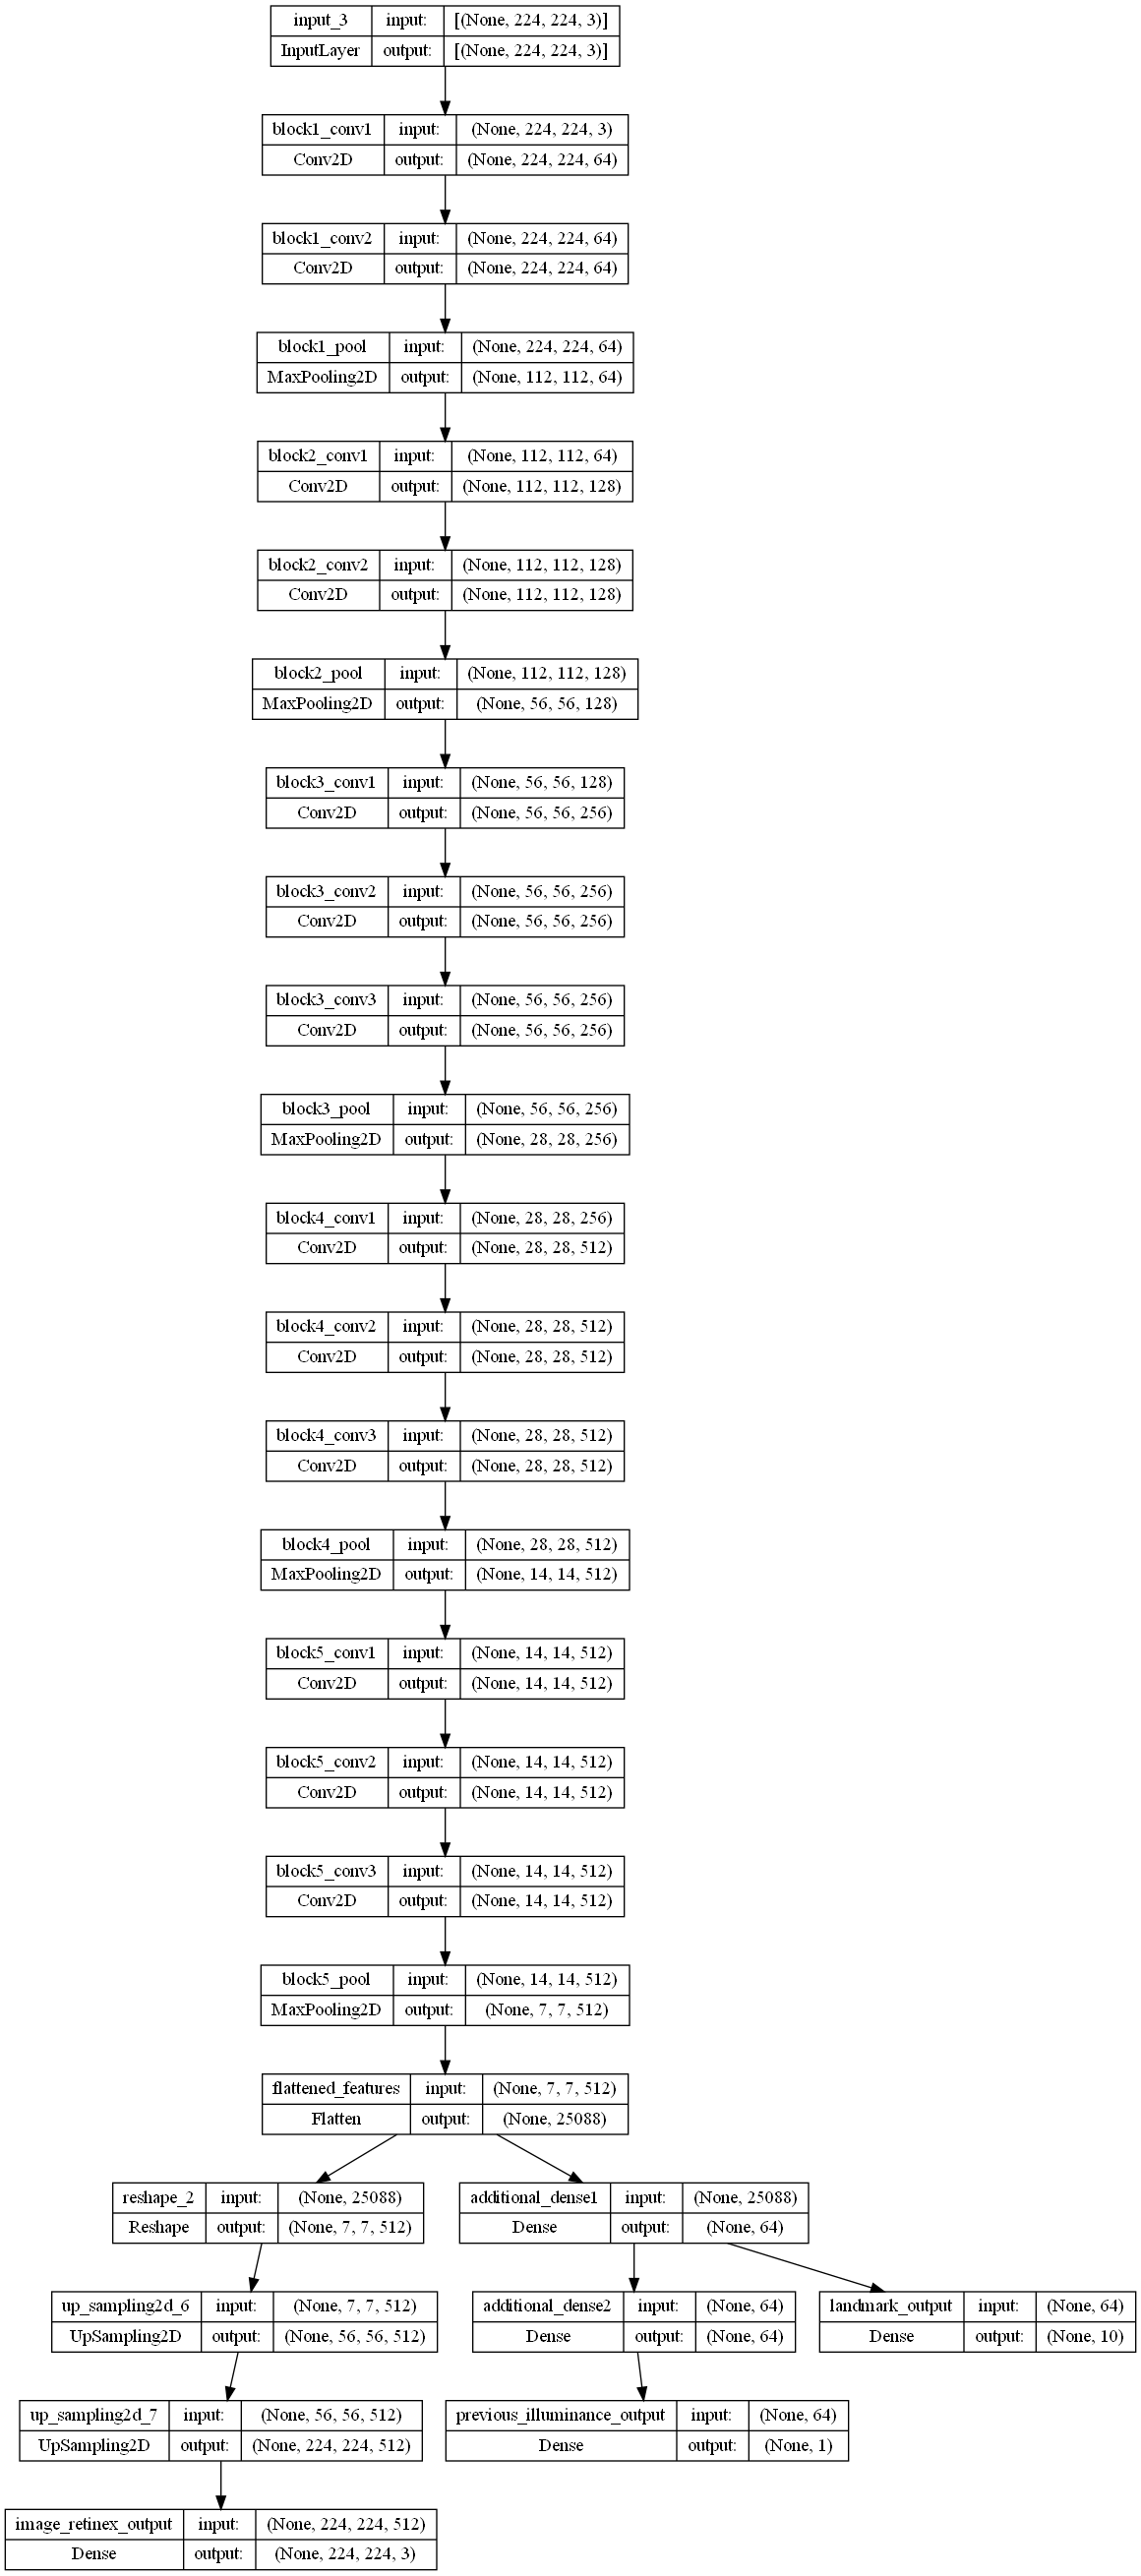

In [11]:
plot_model(multi_task_model, to_file='multitaskModel_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
# ===================== FULL DATA SETUP =====================
# ===================== setup data values as np.array and vstack =====================

trainIllumsRawArray = np.array(trainIllumsRaw)
trainIllumsRetArray = np.array(trainIllumsRet)

evalIllumsRawArray = np.array(evalIllumsRaw)
evalIllumsRetArray = np.array(evalIllumsRet)

Y_train = np.vstack((trainLandmarks, trainIllumsRaw, trainIllumsRet)).T
Y_val = np.vstack((evalLandmarks, evalIllumsRaw, evalIllumsRet)).T

# ===================== setup landmark values =====================

data = Y_train

# Extract numerical values from the dictionaries
numerical_values = []

for row in data:
    row_values = []
    for element in row:
        if isinstance(element, dict):
            # Extract numerical values from the dictionary
            dict_values = [val for key, val in element.items() if isinstance(val, tuple)]
            for tpl in dict_values:
                for value in tpl:
                    if isinstance(value, (int, float)):
                        row_values.append(value)
    numerical_values.append(row_values)

numerical_values = np.array(numerical_values)
# print(numerical_values)

data = Y_val

# Extract numerical values from the dictionaries
valNumerical_values = []

for row in data:
    row_values = []
    for element in row:
        if isinstance(element, dict):
            # Extract numerical values from the dictionary
            dict_values = [val for key, val in element.items() if isinstance(val, tuple)]
            for tpl in dict_values:
                for value in tpl:
                    if isinstance(value, (int, float)):
                        row_values.append(value)
    valNumerical_values.append(row_values)

valNumerical_values = np.array(valNumerical_values)
# print(valNumerical_values)

# ===================== setup train_datagen and val_datagen =====================

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(r'data\Training', 
                                                    target_size=(224, 224), 
                                                    batch_size=100, 
                                                    class_mode='input')

for batch in train_generator:
    images, labels = batch
    break
    
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

train_generator = train_datagen.flow_from_directory(r'data\RetTraining', 
                                                    target_size=(224, 224), 
                                                    batch_size=100,
                                                    class_mode='input')

for batch in train_generator:
    retImages, labels = batch
    break

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

val_generator = train_datagen.flow_from_directory(r'data\Evaluation', 
                                                    target_size=(224, 224), 
                                                    batch_size=100, 
                                                    class_mode='input')

for batch in val_generator:
    valImages, labels = batch
    break
    
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

val_generator = train_datagen.flow_from_directory(r'data\RetEvaluation', 
                                                    target_size=(224, 224), 
                                                    batch_size=100,
                                                    class_mode='input')

for batch in val_generator:
    valRetImages, labels = batch
    break

# ===================== setup train_datagen and val_datagen (to follow) =====================
    
# ===================== setup tensors =====================    

imageTensor = tf.convert_to_tensor(images)
landmarkTensor = tf.convert_to_tensor(numerical_values)
illuminanceTensor = tf.convert_to_tensor(trainIllumsRawArray)
illumsRetTensor = tf.convert_to_tensor(trainIllumsRetArray)
imageRetTensor = tf.convert_to_tensor(retImages)

valImageTensor = tf.convert_to_tensor(valImages)
valLandmarkTensor = tf.convert_to_tensor(valNumerical_values)
valIlluminanceTensor = tf.convert_to_tensor(trainIllumsRawArray)
valIllumsRetTensor = tf.convert_to_tensor(trainIllumsRetArray)
valImageRetTensor = tf.convert_to_tensor(valRetImages)

validation_data = (valImageTensor, {
    'landmark_output': valLandmarkTensor,
    'previous_illuminance_output': valIlluminanceTensor,
    'image_retinex_output': valImageRetTensor
})

print("Done!")

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Done!


In [33]:
# ===================== CALLBACK FUNCTION =====================
class InputOutputShapeCallback(Callback):
    def __init__(self, input_data, task_names):
        super().__init__()
        self.input_data = input_data
        self.task_names = task_names

    def on_epoch_begin(self, epoch, logs=None):
        # Get the model's first layer (input layer) and last layer (output layer)
        input_layer = self.model.layers[0]
        output_layers = self.model.layers[1:]  # Exclude the input layer

        # Print the shapes of the input and output tensors of the model
        print(f"Input Data Shape: {self.input_data.shape}")
        print(f"Input Layer Shape: {input_layer.input_shape}")

        # Print the shapes of the output tensors for each task
        for task_name, output_layer in zip(self.task_names, output_layers):
            print(f"Output Layer Shape for {task_name}: {output_layer.output_shape}")

# List of task names
task_names = ['landmark_output', 'previous_illuminance_output', 'image_retinex_output']

# Create an instance of the callback with input data and task names
shape_callback = InputOutputShapeCallback(input_data=imageTensor, task_names=task_names)

In [35]:
history = multi_task_model.fit(x=imageTensor,
                              y=[landmarkTensor, illumsRetTensor, imageRetTensor],
                              epochs=50, validation_data=validation_data,
                              batch_size=10)


# history = multi_task_model.fit(x=imageTensor,
#                                y={'landmark_output': landmarkTensor, 
#                                 'previous_illuminance_output': illuminanceTensor, 
#                                 'illuminance_retinex_output': illumsRetTensor},
#                                epochs=10,
#                                batch_size=4,
#                                callbacks=[shape_callback])

Epoch 1/50
10/10 [==============================] - 5s 336ms/step - loss: 952074.2500 - landmark_output_loss: 950928.2500 - previous_illuminance_output_loss: 229.9055 - image_retinex_output_loss: 916.1258 - landmark_output_mse: 950928.2500 - landmark_output_accuracy: 0.0000e+00 - previous_illuminance_output_mse: 229.9055 - previous_illuminance_output_accuracy: 0.0000e+00 - image_retinex_output_mse: 916.1259 - image_retinex_output_accuracy: 0.3208 - val_loss: 77692.2266 - val_landmark_output_loss: 77656.2734 - val_previous_illuminance_output_loss: 0.0899 - val_image_retinex_output_loss: 35.8642 - val_landmark_output_mse: 77656.2734 - val_landmark_output_accuracy: 0.0000e+00 - val_previous_illuminance_output_mse: 0.0899 - val_previous_illuminance_output_accuracy: 0.0000e+00 - val_image_retinex_output_mse: 35.8642 - val_image_retinex_output_accuracy: 0.1333
Epoch 2/50
10/10 [==============================] - 3s 284ms/step - loss: 57350.7500 - landmark_output_loss: 57251.2539 - previous_il

Epoch 11/50
10/10 [==============================] - 3s 275ms/step - loss: 35849.4844 - landmark_output_loss: 35848.8086 - previous_illuminance_output_loss: 0.2101 - image_retinex_output_loss: 0.4667 - landmark_output_mse: 35848.8086 - landmark_output_accuracy: 0.0100 - previous_illuminance_output_mse: 0.2101 - previous_illuminance_output_accuracy: 0.0000e+00 - image_retinex_output_mse: 0.4667 - image_retinex_output_accuracy: 0.3795 - val_loss: 39807.1172 - val_landmark_output_loss: 39806.5547 - val_previous_illuminance_output_loss: 0.0899 - val_image_retinex_output_loss: 0.4683 - val_landmark_output_mse: 39806.5547 - val_landmark_output_accuracy: 0.0000e+00 - val_previous_illuminance_output_mse: 0.0899 - val_previous_illuminance_output_accuracy: 0.0000e+00 - val_image_retinex_output_mse: 0.4683 - val_image_retinex_output_accuracy: 0.2346
Epoch 12/50
10/10 [==============================] - 3s 281ms/step - loss: 35753.6758 - landmark_output_loss: 35752.9648 - previous_illuminance_outpu

Epoch 21/50
10/10 [==============================] - 3s 277ms/step - loss: 35905.1289 - landmark_output_loss: 35904.4570 - previous_illuminance_output_loss: 0.2101 - image_retinex_output_loss: 0.4575 - landmark_output_mse: 35904.4570 - landmark_output_accuracy: 0.0100 - previous_illuminance_output_mse: 0.2101 - previous_illuminance_output_accuracy: 0.0000e+00 - image_retinex_output_mse: 0.4575 - image_retinex_output_accuracy: 0.2844 - val_loss: 39907.3164 - val_landmark_output_loss: 39906.7773 - val_previous_illuminance_output_loss: 0.0899 - val_image_retinex_output_loss: 0.4437 - val_landmark_output_mse: 39906.7773 - val_landmark_output_accuracy: 0.0000e+00 - val_previous_illuminance_output_mse: 0.0899 - val_previous_illuminance_output_accuracy: 0.0000e+00 - val_image_retinex_output_mse: 0.4437 - val_image_retinex_output_accuracy: 0.2066
Epoch 22/50
10/10 [==============================] - 3s 278ms/step - loss: 35809.9258 - landmark_output_loss: 35809.2656 - previous_illuminance_outpu

Epoch 31/50
10/10 [==============================] - 3s 272ms/step - loss: 35742.8633 - landmark_output_loss: 35742.1875 - previous_illuminance_output_loss: 0.2101 - image_retinex_output_loss: 0.4662 - landmark_output_mse: 35742.1875 - landmark_output_accuracy: 0.0100 - previous_illuminance_output_mse: 0.2101 - previous_illuminance_output_accuracy: 0.0000e+00 - image_retinex_output_mse: 0.4662 - image_retinex_output_accuracy: 0.3748 - val_loss: 39621.3242 - val_landmark_output_loss: 39620.7852 - val_previous_illuminance_output_loss: 0.0899 - val_image_retinex_output_loss: 0.4474 - val_landmark_output_mse: 39620.7852 - val_landmark_output_accuracy: 0.0000e+00 - val_previous_illuminance_output_mse: 0.0899 - val_previous_illuminance_output_accuracy: 0.0000e+00 - val_image_retinex_output_mse: 0.4474 - val_image_retinex_output_accuracy: 0.2096
Epoch 32/50
10/10 [==============================] - 3s 273ms/step - loss: 35720.0234 - landmark_output_loss: 35719.3594 - previous_illuminance_outpu

Epoch 41/50
10/10 [==============================] - 3s 276ms/step - loss: 35694.0703 - landmark_output_loss: 35693.4141 - previous_illuminance_output_loss: 0.2101 - image_retinex_output_loss: 0.4466 - landmark_output_mse: 35693.4141 - landmark_output_accuracy: 0.0100 - previous_illuminance_output_mse: 0.2101 - previous_illuminance_output_accuracy: 0.0000e+00 - image_retinex_output_mse: 0.4466 - image_retinex_output_accuracy: 0.3248 - val_loss: 39593.8555 - val_landmark_output_loss: 39593.3516 - val_previous_illuminance_output_loss: 0.0899 - val_image_retinex_output_loss: 0.4115 - val_landmark_output_mse: 39593.3516 - val_landmark_output_accuracy: 0.0000e+00 - val_previous_illuminance_output_mse: 0.0899 - val_previous_illuminance_output_accuracy: 0.0000e+00 - val_image_retinex_output_mse: 0.4115 - val_image_retinex_output_accuracy: 0.1572
Epoch 42/50
10/10 [==============================] - 3s 298ms/step - loss: 35976.3086 - landmark_output_loss: 35975.6523 - previous_illuminance_outpu

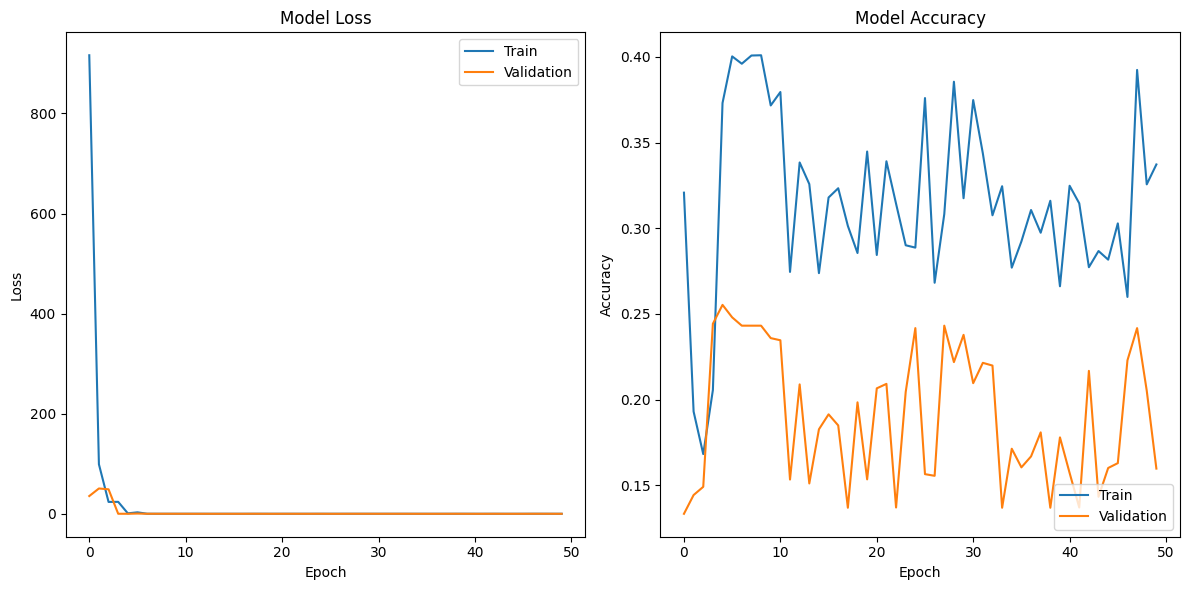

In [36]:
historyToCsv()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['image_retinex_output_loss'])
plt.plot(history.history['val_image_retinex_output_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['image_retinex_output_accuracy'])
plt.plot(history.history['val_image_retinex_output_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

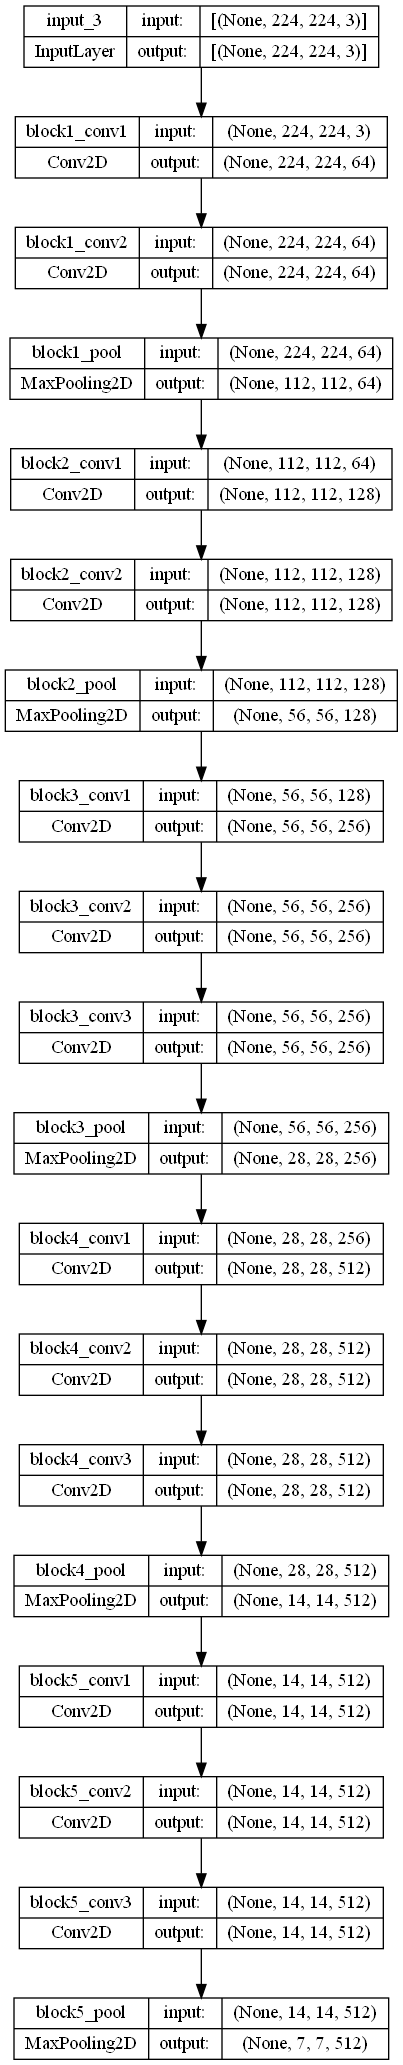

In [12]:
# retain weights and remove top layer
output_layer = multi_task_model.get_layer('block5_pool').output

drowsiness_model = Model(inputs=multi_task_model.input, outputs=output_layer)

# drowsiness_model.summary()
# tf.keras.utils.plot_model(drowsiness_model)
from keras.utils.vis_utils import plot_model
plot_model(drowsiness_model, to_file='drowsinessModel_plot.png', show_shapes=True, show_layer_names=True)

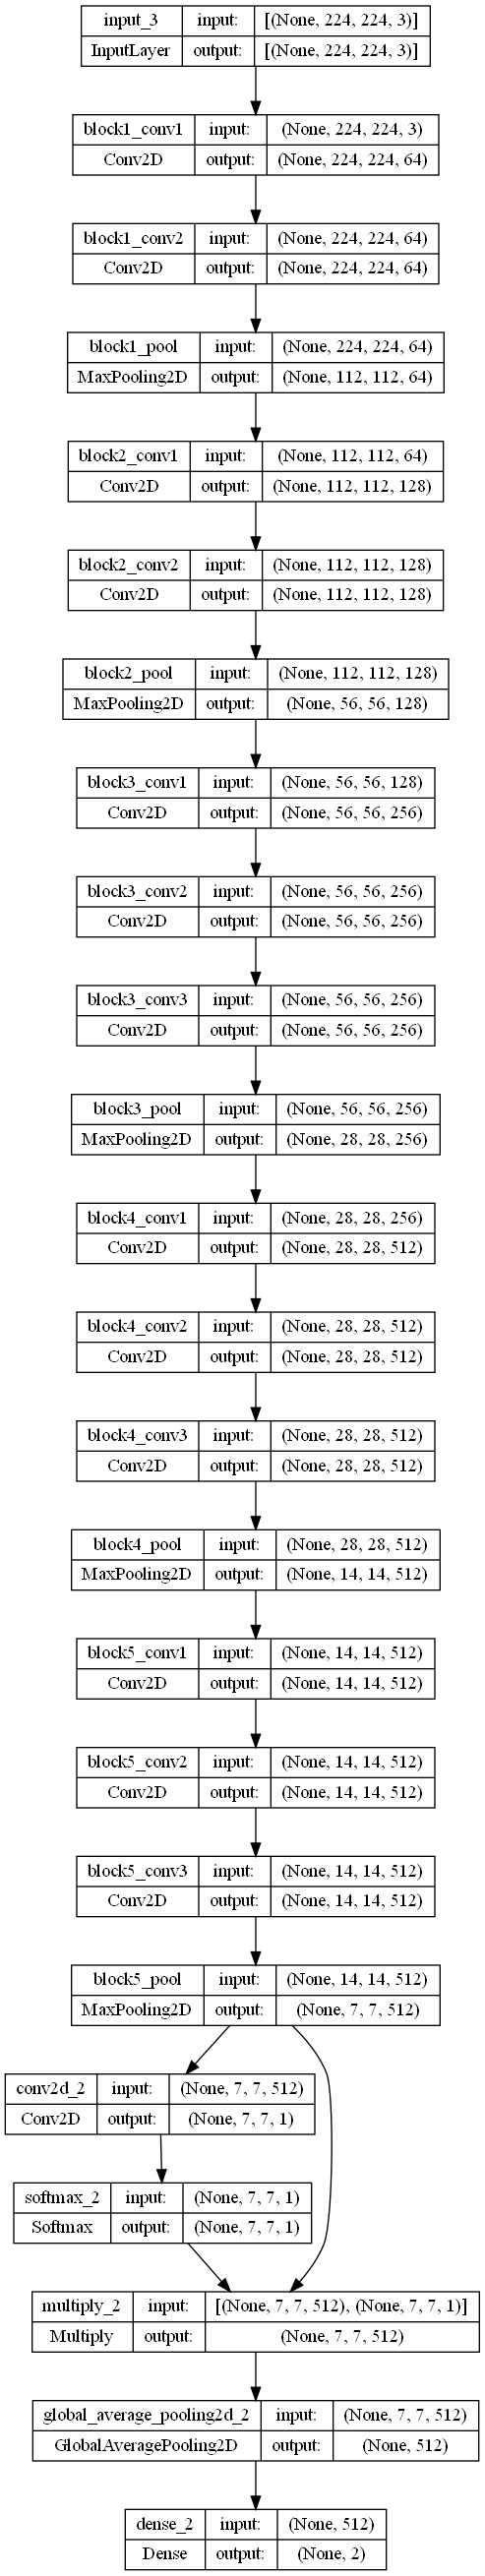

In [16]:
existing_output = drowsiness_model.output

spatial_attention = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(existing_output)
spatial_attention = tf.keras.layers.Softmax()(spatial_attention)
output_tensor = tf.keras.layers.Multiply()([existing_output, spatial_attention])

# Add Global Average Pooling layer
output_tensor = tf.keras.layers.GlobalAveragePooling2D()(output_tensor)

# Add output layer with two classes and softmax activation
predictions = tf.keras.layers.Dense(2, activation='softmax')(output_tensor)

# Create the new model with the modified top layers
new_model = Model(inputs=drowsiness_model.input, outputs=predictions)

# new_model.summary()
plot_model(new_model, to_file='adjustedDrowsinessModel_plot.png', show_shapes=True, show_layer_names=True)